# Modeling
## Predicting Rates of Chronic Absenteeism

When we used Last Year's % Chronically Absent to Predict Next Year's as a baseline comparison, we found that this one variable led to an R2 of .64 for linear regression and an accuracy of .77 with a Decision Tree. Meaning the previous models in notebook 1.3 were not outperforming this baseline. So to improve model performance...

In this notebook we added 5 additional time series features:
- the difference between each value's '% Chronically Absent' and the 5 year averages of '% Chronically Absent'  (grouped by DBN, Grade, & Demographic Variable)
- the difference between each value's '% Attendance' and the 5 year averages of '% Attendance'  (grouped by DBN, Grade, & Demographic Variable)
- the difference between each value's '% Chronically Absent' and the 2 year averages of '% Chronically Absent'  (grouped by DBN, Grade, & Demographic Variable)
- the difference between each value's '% Chronically Absent' and the 2 year averages of '% Chronically Absent'  (grouped by DBN, Grade, & Demographic Variable)
- % Chronic Absent (which is essentialy the previous year's % Chronic Absent as we are predicing the following year.

Both '% Chronically Absent' and '% Attendance' are variables that had high feature importance (see notebook 1.3), we wanted to build in additional features that may help with a model's predictive power. The addition of the variables led improvement in accuracy scores across models (see notes below).

### Imports 

In [84]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier 
import datetime
from pandas_profiling import ProfileReport

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn import tree, metrics
from io import StringIO  
from IPython.display import Image  
#import pydotplus

import matplotlib.style as style
style.use('fivethirtyeight')

In [85]:
#load processed data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/data/processed'
os.chdir(path)

In [86]:
#load data for regression and classification models
df_regressor = pd.read_csv('more_variables_attendance_2013_18_regressor.csv', dtype={'District_Number': object})

df_classifier = pd.read_csv('more_variables_attendance_2013_18_classifier.csv', dtype={'District_Number': object})

In [87]:
#check to ensure District Number is correctly an object, not int
df_regressor.dtypes

Grade                                         object
Year                                          object
Demographic Variable                          object
% Attendance                                 float64
% Chronically Absent                         float64
Next Year % Chronically Absent               float64
District_Number                               object
% Attendance - diff from 5 yr avg            float64
% Attendance - diff from 2 yr avg            float64
% Chronically Absent - diff from 5 yr avg    float64
% Chronically Absent - diff from 2 yr avg    float64
dtype: object

This time we will try the models and maintain the feature `% Chronically Absent`, as we want to increase model accuracy.

In [88]:
#create dummy variables for the two data frames
df_regressor_dummies = pd.get_dummies(df_regressor)

#remove target variable from classification data, so it does not get turned into a dummy variable
df_classifier_dummies = pd.get_dummies(df_classifier.drop(columns=['Chronically_Absent_Next_Year']))

#save target variable for classification
target_classifier = df_classifier['Chronically_Absent_Next_Year']

print(df_classifier_dummies.shape)
print(df_regressor_dummies.shape)

(448835, 73)
(448835, 74)


In [89]:
#define variables for regressor
X = df_regressor_dummies.drop(columns=['Next Year % Chronically Absent'])
y = df_regressor_dummies['Next Year % Chronically Absent']

In [90]:
#train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Modeling

### Initial Benchmark 
#### Using Last Year's % Chronically Absent to Predict Next Year's

In [32]:
#create linear regression with only previous year's '% Chronically Absent' as X variable
dummy_lr = LinearRegression().fit(pd.DataFrame(X_train['% Chronically Absent']), y_train)

In [33]:
#make predictions
y_dum_tr_pred = dummy_lr.predict(pd.DataFrame(X_train['% Chronically Absent']))
y_dumm_te_pred = dummy_lr.predict(pd.DataFrame(X_test['% Chronically Absent']))

In [34]:
#get R2 - train, test
r2 = r2_score(y_train, y_dum_tr_pred), r2_score(y_test, y_dumm_te_pred)
print('r2:', r2)

r2: (0.6629387636783622, 0.6379189299689096)


In [35]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_dum_tr_pred), mean_absolute_error(y_test, y_dumm_te_pred)
print('mae:', mae)

mae: (7.493247913833839, 7.731187252475798)


In [36]:
# MSE - train, test
mse = mean_squared_error(y_train, y_dum_tr_pred), mean_squared_error(y_test, y_dumm_te_pred)
print('mse:', mse)

mse: (105.7232210816451, 112.96321736840633)


It seems that if one only used last year's `% Chronically Absent` you would predict `Next Year % Chronically Absent` correctly 63.8% of the time. So any future models would need to improve on that.

### Linear Regression Model

In [91]:
lm = LinearRegression().fit(X_train, y_train)

In [92]:
#Make predictions using the model on both train and test splits
y_tr_pred = lm.predict(X_train)
y_te_pred = lm.predict(X_test)

In [93]:
#Assess model performance
# r^2 - train, test
r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
print('r2:', r2)

r2: (0.847150018751543, 0.6862648134079694)


In [94]:
#MAE - train, test
mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
print('mae:', mae)

mae: (4.8944715287363305, 7.115199420440165)


In [95]:
# MSE - train, test
mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
print('mse:', mse)

mse: (47.443125515116115, 97.62840654684464)


### Random Forest Regression Model

In [96]:
rf_model = RandomForestRegressor()

In [97]:
%%time
rf_model.fit(X_train, y_train)
y_tr_pred = rf_model.predict(X_train)
y_te_pred = rf_model.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

CPU times: user 12min 28s, sys: 19.8 s, total: 12min 47s
Wall time: 13min 37s


(0.9883989097838864, 0.7010111034155115)

In [98]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(1.1704781354436808, 6.883194158144508)

In [99]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(3.600863897657942, 93.03964233600695)

## Initial Classification Models

In [113]:
#define variables for classifier
X_c = df_classifier_dummies
y_c = target_classifier

In [114]:
# dividing X_c, y_c into train and test data 
#X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, random_state = 0) 

#Time series Train test split for the 5 school years years
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X_c):
    X_train, X_test = X_c.iloc[train_index, :], X_c.iloc[test_index,:]
    y_train, y_test = y_c.iloc[train_index], y_c.iloc[test_index]

### Establish Baseline
#### Using Last Year's % Chronically Absent to Predict Next Year's

In [115]:
# training a DescisionTreeClassifier 
baseline_dtree_model = DecisionTreeClassifier(max_depth = 2).fit(pd.DataFrame(X_train['% Chronically Absent']), y_train) 
baseline_dtree_predictions = baseline_dtree_model.predict(pd.DataFrame(X_test['% Chronically Absent']))
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, baseline_dtree_predictions) 

In [116]:
print(baseline_dtree_model.score(pd.DataFrame(X_test['% Chronically Absent']), y_test))
print(cm)
print(classification_report(y_test, baseline_dtree_predictions))

0.7697480114965577
[[ 6351    64  6565]
 [   22  7611  4376]
 [ 2048  4149 43619]]
              precision    recall  f1-score   support

        High       0.75      0.49      0.59     12980
         Low       0.64      0.63      0.64     12009
      Medium       0.80      0.88      0.84     49816

    accuracy                           0.77     74805
   macro avg       0.73      0.67      0.69     74805
weighted avg       0.77      0.77      0.76     74805



This suggests that a model would have to outperform 76.9% to be considered an improvement over the baseline.

### Decision Tree

In [117]:
# training a DescisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
dtree_predictions = dtree_model.predict(X_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, dtree_predictions) 

In [118]:
print(dtree_model.score(X_test, y_test))
print(cm)
print(classification_report(y_test, dtree_predictions))

0.7697346434061895
[[ 9274    24  3682]
 [   74  7243  4692]
 [ 5532  3221 41063]]
              precision    recall  f1-score   support

        High       0.62      0.71      0.67     12980
         Low       0.69      0.60      0.64     12009
      Medium       0.83      0.82      0.83     49816

    accuracy                           0.77     74805
   macro avg       0.71      0.71      0.71     74805
weighted avg       0.77      0.77      0.77     74805



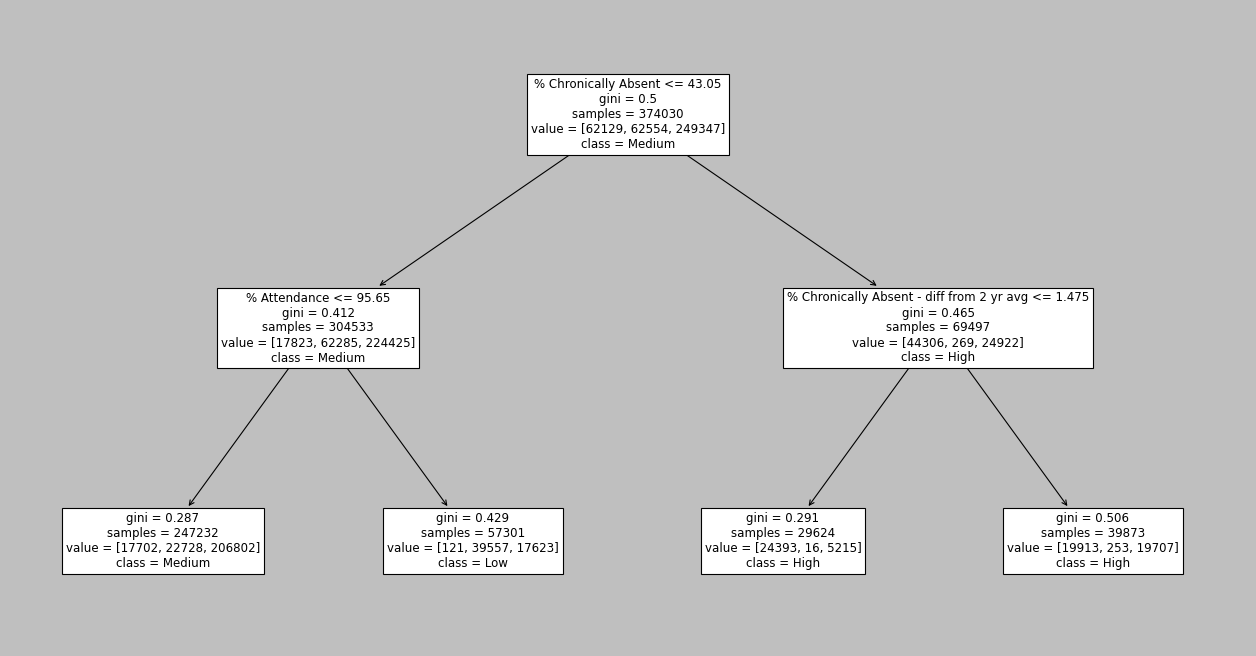

In [119]:
plt.style.use('classic')
#plot decision tree
plt.figure(figsize=(20,10))
tree.plot_tree(dtree_model, class_names=dtree_model.classes_, feature_names=X_train.columns)
plt.show()

### Tuning Decision Tree Classifier

In [133]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 9),
              #"max_features": randint(1, 9),
              #"min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 8}
Best score is 0.8475496617918349


In [134]:
# Predict the labels of the test set: y_pred
y_pred = tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 6576    25  6379]
 [   33  8072  3904]
 [ 2140  4436 43240]]
              precision    recall  f1-score   support

        High       0.75      0.51      0.61     12980
         Low       0.64      0.67      0.66     12009
      Medium       0.81      0.87      0.84     49816

    accuracy                           0.77     74805
   macro avg       0.73      0.68      0.70     74805
weighted avg       0.77      0.77      0.77     74805



In [137]:
#create model with tuned hyperparameters
tuned_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8)

# Fit it to the data
tuned_tree.fit(X_train, y_train)
y_pred = tree_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.75      0.51      0.61     12980
         Low       0.64      0.67      0.66     12009
      Medium       0.81      0.87      0.84     49816

    accuracy                           0.77     74805
   macro avg       0.73      0.68      0.70     74805
weighted avg       0.77      0.77      0.77     74805



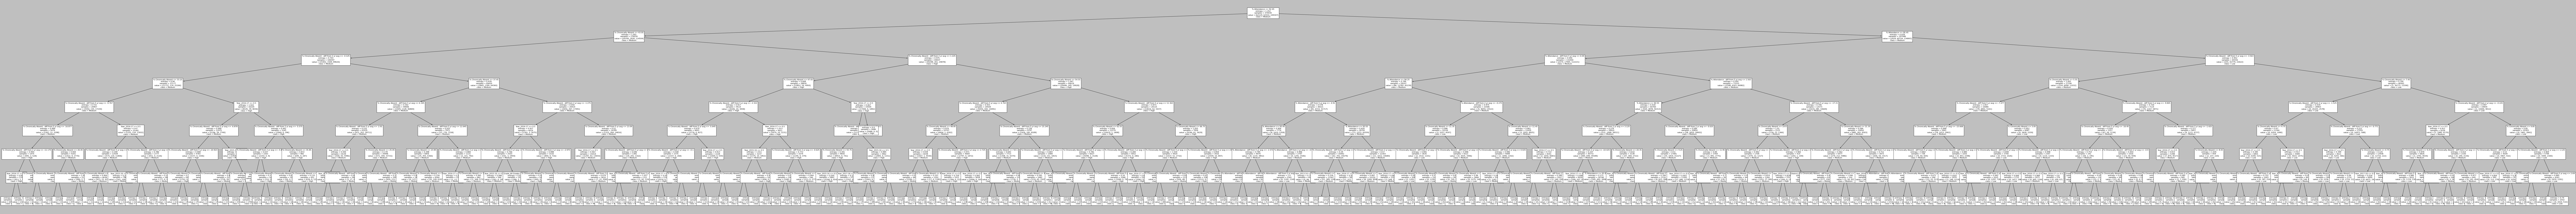

In [161]:
#plot decision tree tuned for hyperparameters
from sklearn import tree
plt.style.use('classic')
plt.figure(figsize=(250,20))
tree.plot_tree(tuned_tree, class_names=tuned_tree.classes_, feature_names=X_train.columns, fontsize=10)
plt.show()

## Naive Bayes Classifier

In [123]:
# training a Naive Bayes classifier 
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_train, y_train) 
gnb_predictions = gnb.predict(X_test) 
  
# accuracy on X_test 
accuracy = gnb.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, gnb_predictions) 

0.5224650758639129


In [124]:
#print confusion matrix and classification report
print(cm)
print(classification_report(y_test, gnb_predictions))

[[10291   239  2450]
 [  814  9492  1703]
 [14487 16029 19300]]
              precision    recall  f1-score   support

        High       0.40      0.79      0.53     12980
         Low       0.37      0.79      0.50     12009
      Medium       0.82      0.39      0.53     49816

    accuracy                           0.52     74805
   macro avg       0.53      0.66      0.52     74805
weighted avg       0.68      0.52      0.52     74805



### Random Forest Classifier

In [125]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_class = RandomForestClassifier().fit(X_train, y_train) 
rf_class_pred = rf_class.predict(X_test) 
  
# accuracy on X_test 
accuracy = rf_class.score(X_test, y_test) 
print(accuracy)
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, rf_class_pred) 

0.8042243165563799
CPU times: user 2min 9s, sys: 4.18 s, total: 2min 14s
Wall time: 2min 22s


In [126]:
#print confusion matrix and classification report
print(cm)
print(classification_report(y_test, rf_class_pred))

[[ 8119    14  4847]
 [   21  7684  4304]
 [ 2633  2826 44357]]
              precision    recall  f1-score   support

        High       0.75      0.63      0.68     12980
         Low       0.73      0.64      0.68     12009
      Medium       0.83      0.89      0.86     49816

    accuracy                           0.80     74805
   macro avg       0.77      0.72      0.74     74805
weighted avg       0.80      0.80      0.80     74805



In [127]:
#see tree depths of random forrest classifier
[estimator.tree_.max_depth for estimator in rf_class.estimators_]

[60,
 53,
 57,
 55,
 59,
 62,
 54,
 62,
 54,
 59,
 55,
 59,
 57,
 50,
 56,
 57,
 56,
 57,
 57,
 55,
 60,
 61,
 60,
 57,
 58,
 54,
 63,
 58,
 56,
 57,
 57,
 55,
 51,
 57,
 55,
 57,
 54,
 57,
 55,
 54,
 54,
 62,
 52,
 56,
 63,
 55,
 56,
 53,
 54,
 62,
 51,
 59,
 55,
 58,
 56,
 53,
 58,
 59,
 62,
 57,
 60,
 51,
 62,
 60,
 73,
 57,
 57,
 47,
 56,
 58,
 55,
 55,
 56,
 52,
 55,
 60,
 55,
 60,
 53,
 57,
 56,
 56,
 56,
 70,
 54,
 54,
 55,
 57,
 54,
 63,
 57,
 60,
 55,
 58,
 52,
 54,
 52,
 53,
 60,
 54]

# Tuning Random Forest Classifier

In [162]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": randint(1, 9),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
rf_tree = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
rf_tree_cv = RandomizedSearchCV(rf_tree, param_dist, cv=5)

# Fit it to the data
rf_tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(rf_tree_cv.best_params_))
print("Best score is {}".format(rf_tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 8}
Best score is 0.7925968505200118


In [163]:
# Predict the labels of the test set: y_pred
y_pred = rf_tree_cv.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 4345    10  8625]
 [    7  6201  5801]
 [  949  1656 47211]]
              precision    recall  f1-score   support

        High       0.82      0.33      0.48     12980
         Low       0.79      0.52      0.62     12009
      Medium       0.77      0.95      0.85     49816

    accuracy                           0.77     74805
   macro avg       0.79      0.60      0.65     74805
weighted avg       0.78      0.77      0.75     74805



### K-Nearest Neighbors

In [164]:
# Create a k-NN classifier
knn = KNeighborsClassifier()

# Fit the classifier to the data
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [165]:
# Predict the labels for the training data X
y_pred = knn.predict(X_test)

In [166]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7808301584118709


In [167]:
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 7769    39  5172]
 [   40  7852  4117]
 [ 3121  3906 42789]]
              precision    recall  f1-score   support

        High       0.71      0.60      0.65     12980
         Low       0.67      0.65      0.66     12009
      Medium       0.82      0.86      0.84     49816

    accuracy                           0.78     74805
   macro avg       0.73      0.70      0.72     74805
weighted avg       0.78      0.78      0.78     74805



Hyperparameter Tuning for KNN ran for several days, yieling no results and was abandoned.

## Choose Model + Feature Importance 

Best performing model is in terms of overall accuracy was the 'entropy' Decision Tree Classifier with max_depth of 7 (84.75% Accuracy), but that is not our best model choice. In many cases school districs would be most focused on the 'High' rates of Chronic Absenteeism (**Meaning 1 standard deviation above the mean)**. For the 'High' class the Random forest classifer would be our first choice model as explained below.

     
It wil depend on what a district needs to manage more, False Positives or False Negatives, in deciding which model is best in reality. 

- too many False positives = may be ok for school districts with less constraintes (ie. larger budgets, more time for this kind of initiative), as they may want to ensure they got all the schools & groups that are at risk of high chronic absenteeism.
- too many False negatives = may be ok for school disctricts with more constraints (ie. smaller budgets, less time for this kind of initiative), as they may want to ensure a school/group they focus on will really need it.


So in fact the Random Forest Model (80.4%) would be a great choice if you want to ensure you limited False Positives (and were ok with under-identifying schools/groups that are at risk of high chronic absenteeism), because the precision is higher while the recall is lower: 

'High' Next_Year_Chronic Absenteesim:
- precision: 0.75
- recall: 0.63
- f1-score: 0.68 
- support: 12980
    
However if you wanted to ensure you limited False Negatives (and were ok with over-identifying schools/groups that are at risk of high chronic absenteeism), then the Naive Bayes Classifer (52% Accuracy) would be the way to go, because although the precision is low the recall is much higher than other models:

'High' Next_Year_Chronic Absenteesim:
- precision: 0.40
- recall: 0.79
- f1-score: 0.53
- support: 12980
  
But if you wanted the model you could most easily explain would be a Descision Tree with max depth 2 (77% accuracy) may be the best choice as its precision vs. recall for the 'High' class have the least difference.
        
'High' Next_Year_Chronic Absenteesim:
- precision: 0.62  
- recall: 0.71
- f1-score: 0.68
- support: 12980

This model is also incredibly straightforward to explain  to schools. As it predicts any school/group that has:

- % Chronically Absent greater than 43.05% as 'High' Next_Year_Chronic Absenteesim 
- % Chronically Absent less than or equal to 43.05% and % Attendance less than or equal to 95.65% as 'Medium' Next_Year_Chronic Absenteesim
- % Chronically Absent less than or equal to 43.05% and % Attendance greater than 95.65% as 'High' Next_Year_Chronic Absenteesim

Feature ranking:
1. feature 1 (0.259725)
2. feature 0 (0.225061)
3. feature 5 (0.084209)
4. feature 4 (0.081441)
5. feature 2 (0.065141)
6. feature 3 (0.060453)
7. feature 24 (0.015531)
8. feature 72 (0.010620)
9. feature 21 (0.009390)
10. feature 22 (0.008656)
11. feature 23 (0.007938)
12. feature 10 (0.006987)
13. feature 27 (0.005768)
14. feature 41 (0.005368)
15. feature 34 (0.004930)
16. feature 19 (0.004908)
17. feature 65 (0.004776)
18. feature 38 (0.004205)
19. feature 30 (0.003745)
20. feature 32 (0.003686)
21. feature 11 (0.003648)
22. feature 6 (0.003628)
23. feature 7 (0.003609)
24. feature 12 (0.003522)
25. feature 13 (0.003505)
26. feature 26 (0.003460)
27. feature 31 (0.003369)
28. feature 14 (0.003365)
29. feature 25 (0.003209)
30. feature 35 (0.003098)
31. feature 59 (0.003060)
32. feature 29 (0.003035)
33. feature 8 (0.002909)
34. feature 39 (0.002895)
35. feature 28 (0.002844)
36. feature 18 (0.002779)
37. feature 37 (0.002716)
38. feature 70 (0.002679)
39. feature 6

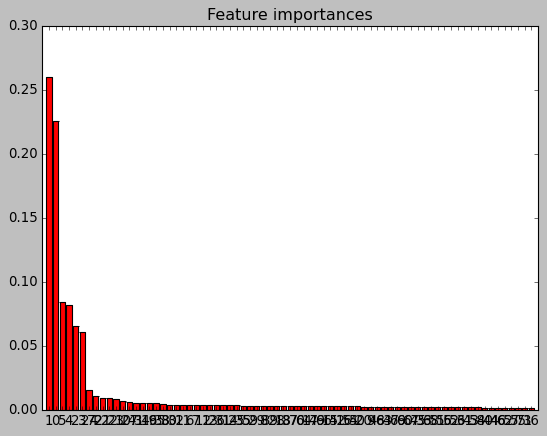

In [136]:
#plot feature importance for random forest classifier model...
importances = rf_class.feature_importances_
std = np.std([rf_class.feature_importances_ for tree in rf_class.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Top 10 Feature ranking:
1. feature 1 (0.259725) - '% Chronically Absent'
2. feature 0 (0.225061) - '% Attendance'
3. feature 5 (0.084209) - '% Chronically Absent - diff from 2 yr avg'
4. feature 4 (0.081441) - '% Chronically Absent - diff from 5 yr avg'
5. feature 2 (0.065141) - '% Attendance - diff from 5 yr avg'
6. feature 3 (0.060453) - '% Attendance - diff from 2 yr avg'
7. feature 24 (0.015531) - 'Year_2016-17'
8. feature 72 (0.010620) - 'District_Number_75'
9. feature 21 (0.009390) - 'Year_2013-14'
10. feature 22 (0.008656) - 'Year_2014-15'

### Saved Best Model

In [159]:
# save the model to disk
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_3/Capstone_3/models'
os.chdir(path)

filename = 'rf_classifier_improved.sav'
pickle.dump(rf_class, open(filename, 'wb'))

In [160]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8042243165563799


## Notes /Summary

- Summary same as 1.3 Notebook (see there)
- Only difference is that data with 5 addtional features was used, which effected the model's predictive power (as explained in the notes above in 'Choose Model + Feature Importance'
- We added new features when we used Last Year's % Chronically Absent to Predict Next Year's as a baseline comparison, we found that this one variable led to an R2 of .64 for linear regression and an accuracy of .77 with a Decision Tree. Meaning the previous models were not outperforming this baseline.

Things to try in the future
- need to generate more features, https://github.com/springboard-curriculum/featuretools/blob/master/Feature%20Engineering.ipynb
- import other dataframes from nycopen data

We could try to turn chronic absenteeism from a multi class categorical variable to a binary variable.. As we are concerned mostly with whether Chronic Absenteeism is 'High' or not.